In [9]:
import pandas as pd
import numpy as np
import requests
import tweepy
import os
import json
import time
import re
import matplotlib.pyplot as plt
import warnings
from IPython.display import Image
from functools import reduce
import re
import seaborn as sns
import datetime
% matplotlib inline


In [10]:
df_twitter_archive= pd.read_csv('twitter-archive-enhanced.csv')
df_twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [11]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
image_request = requests.get(url, allow_redirects=True)

open('image_predictions.tsv', 'wb').write(image_request.content)

335079

In [12]:
df_image_predictions = pd.read_csv('image_predictions.tsv', sep= '\t')
df_image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [13]:
auth = tweepy.OAuthHandler('5Uur0mo4ol2kB8yhtZ1VxXS0u', 'h8E7fSpXWiMoBel7G1ZOAeu4Mgru0v0MtxH5ehYE1RKM89SiBH')
auth.set_access_token('303562412-ct9aNnU0FQR0UKJVn1i1W3Y8omqSewiQWUcRaygB', 'D3qslrbdOU5fqTOp951kOIuZbkeTPBodnjNYoEGFR63Ft')
api = tweepy.API(auth, wait_on_rate_limit = True, wait_on_rate_limit_notify = True)

In [14]:
list_of_tweets = []
cant_find_tweets_for_those_ids = []
for tweet_id in df_twitter_archive['tweet_id']:   
    try:
        list_of_tweets.append(api.get_status(tweet_id))
    except Exception as e:
        cant_find_tweets_for_those_ids.append(tweet_id)

Rate limit reached. Sleeping for: 663


KeyboardInterrupt: 

In [15]:
print("The list of tweets" ,len(list_of_tweets))
print("The list of tweets no found" , len(cant_find_tweets_for_those_ids))

The list of tweets 0
The list of tweets no found 0


In [16]:
df_list = []

with open('tweet-json.txt', 'r') as file:
    for line in file:
        tweet = json.loads(line)
        print('tweet', tweet.keys(), '\n')
        tweet_id = tweet['id']
        retweet_count = tweet['retweet_count']
        fav_count = tweet['favorite_count']
        df_list.append({'tweet_id':tweet_id,
                       'retweet_count': retweet_count,
                       'favorite_count': fav_count})
        
api_df_now = pd.DataFrame(df_list)
api_df_now.head()

tweet dict_keys(['created_at', 'id', 'id_str', 'full_text', 'truncated', 'display_text_range', 'entities', 'extended_entities', 'source', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors', 'is_quote_status', 'retweet_count', 'favorite_count', 'favorited', 'retweeted', 'possibly_sensitive', 'possibly_sensitive_appealable', 'lang']) 

tweet dict_keys(['created_at', 'id', 'id_str', 'full_text', 'truncated', 'display_text_range', 'entities', 'extended_entities', 'source', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors', 'is_quote_status', 'retweet_count', 'favorite_count', 'favorited', 'retweeted', 'possibly_sensitive', 'possibly_sensitive_appealable', 'lang']) 

tweet dict_keys(['created_at', 'id', 'id_str', 'full_text', 

tweet dict_keys(['created_at', 'id', 'id_str', 'full_text', 'truncated', 'display_text_range', 'entities', 'extended_entities', 'source', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors', 'is_quote_status', 'retweet_count', 'favorite_count', 'favorited', 'retweeted', 'possibly_sensitive', 'possibly_sensitive_appealable', 'lang']) 

tweet dict_keys(['created_at', 'id', 'id_str', 'full_text', 'truncated', 'display_text_range', 'entities', 'extended_entities', 'source', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors', 'is_quote_status', 'retweet_count', 'favorite_count', 'favorited', 'retweeted', 'possibly_sensitive', 'possibly_sensitive_appealable', 'lang']) 

tweet dict_keys(['created_at', 'id', 'id_str', 'full_text', 

tweet dict_keys(['created_at', 'id', 'id_str', 'full_text', 'truncated', 'display_text_range', 'entities', 'extended_entities', 'source', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors', 'is_quote_status', 'retweet_count', 'favorite_count', 'favorited', 'retweeted', 'possibly_sensitive', 'possibly_sensitive_appealable', 'lang']) 

tweet dict_keys(['created_at', 'id', 'id_str', 'full_text', 'truncated', 'display_text_range', 'entities', 'extended_entities', 'source', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors', 'is_quote_status', 'retweet_count', 'favorite_count', 'favorited', 'retweeted', 'possibly_sensitive', 'possibly_sensitive_appealable', 'lang']) 

tweet dict_keys(['created_at', 'id', 'id_str', 'full_text', 

tweet dict_keys(['created_at', 'id', 'id_str', 'full_text', 'truncated', 'display_text_range', 'entities', 'extended_entities', 'source', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors', 'is_quote_status', 'retweet_count', 'favorite_count', 'favorited', 'retweeted', 'possibly_sensitive', 'possibly_sensitive_appealable', 'lang']) 

tweet dict_keys(['created_at', 'id', 'id_str', 'full_text', 'truncated', 'display_text_range', 'entities', 'extended_entities', 'source', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors', 'is_quote_status', 'retweet_count', 'favorite_count', 'favorited', 'retweeted', 'possibly_sensitive', 'possibly_sensitive_appealable', 'lang']) 

tweet dict_keys(['created_at', 'id', 'id_str', 'full_text', 

,favorite_count,retweet_count,tweet_id
0,39467,8853,892420643555336193
1,33819,6514,892177421306343426
2,25461,4328,891815181378084864
3,42908,8964,891689557279858688
4,41048,9774,891327558926688256


In [17]:
api_df_now.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
favorite_count    2354 non-null int64
retweet_count     2354 non-null int64
tweet_id          2354 non-null int64
dtypes: int64(3)
memory usage: 55.2 KB


In [18]:
errors = []
if not os.path.isfile('tweet-json.txt'):
    # create the file and write on it
    with open ('tweet-json.txt', 'wb') as file:
        for tweet_id in archive['tweet_id']:
            try:
                status = api.get_status(tweet_id, wait_on_rate_limit=True,  wait_on_rate_limit_notify=True, tweet_mode = 'extended')
                json.dump(status._json, file)
                file.write('\n')
            except Exception as e:
                print("Error on tweet id {}".format(tweet_id) + ";" + str(e))
                errors.append(tweet_id)

In [19]:
df_twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [20]:
df_image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [21]:
df_twitter_archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [22]:
print(df_twitter_archive.loc[df_twitter_archive.rating_denominator == 11, 'text']) 
print(df_twitter_archive.loc[df_twitter_archive.rating_denominator == 2, 'text']) 
print(df_twitter_archive.loc[df_twitter_archive.rating_denominator == 16, 'text']) 
print(df_twitter_archive.loc[df_twitter_archive.rating_denominator == 15, 'text'])
print(df_twitter_archive.loc[df_twitter_archive.rating_denominator == 7, 'text'])

784     RT @dog_rates: After so many requests, this is...
1068    After so many requests, this is Bretagne. She ...
1662    This is Darrel. He just robbed a 7/11 and is i...
Name: text, dtype: object
2335    This is an Albanian 3 1/2 legged  Episcopalian...
Name: text, dtype: object
1663    I'm aware that I could've said 20/16, but here...
Name: text, dtype: object
342    @docmisterio account started on 11/15/15
Name: text, dtype: object
516    Meet Sam. She smiles 24/7 &amp; secretly aspir...
Name: text, dtype: object


In [28]:
print(df_twitter_archive['text'][784]) 
print(df_twitter_archive['text'][1068]) 
print(df_twitter_archive['text'][1662]) 
print(df_twitter_archive['text'][2335]) 
print(df_twitter_archive['text'][1663]) 
print(df_twitter_archive['text'][342]) 
print(df_twitter_archive['text'][516]) 

RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…
After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ
This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5
This is an Albanian 3 1/2 legged  Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv
I'm aware that I could've said 20/16, but here at WeRateDogs we are very professional. An inconsistent rating scale is simply irresponsible
@docmisterio account started on 11/15/15
Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. 
Keep Sam smiling by clicking and sharing this link:
https://t.co/98tB8y7y7t https://t.co/LouL5vdvxx


In [29]:
df_twitter_archive['name'].value_counts()

None            745
a                55
Charlie          12
Oliver           11
Lucy             11
Cooper           11
Tucker           10
Lola             10
Penny            10
Bo                9
Winston           9
Sadie             8
the               8
an                7
Bailey            7
Daisy             7
Buddy             7
Toby              7
Jack              6
Leo               6
Milo              6
Scout             6
Rusty             6
Bella             6
Oscar             6
Dave              6
Jax               6
Stanley           6
Koda              6
Finn              5
               ... 
Clybe             1
Colin             1
Iggy              1
Arlen             1
Kona              1
Kara              1
Sailer            1
Gustaf            1
Biden             1
Dietrich          1
Pancake           1
Brady             1
Bruiser           1
Alexanderson      1
Ashleigh          1
Jackie            1
Clyde             1
Yoda              1
Buddah            1


In [30]:
df_twitter_archive[df_twitter_archive.tweet_id.duplicated()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [31]:
df_twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [32]:
df_image_predictions.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1247,747600769478692864,https://pbs.twimg.com/media/CmAC7ehXEAAqSuW.jpg,1,Chesapeake_Bay_retriever,0.804363,True,Weimaraner,0.054431,True,Labrador_retriever,0.043268,True
2016,879862464715927552,https://pbs.twimg.com/media/DDXmPrbWAAEKMvy.jpg,3,basset,0.813507,True,beagle,0.146654,True,cocker_spaniel,0.009485,True
845,695095422348574720,https://pbs.twimg.com/media/CaV5mRDXEAAR8iG.jpg,1,papillon,0.227784,True,Chihuahua,0.218128,True,Border_collie,0.093457,True
2008,878057613040115712,https://pbs.twimg.com/media/DC98vABUIAA97pz.jpg,1,French_bulldog,0.839097,True,Boston_bull,0.078799,True,toy_terrier,0.015243,True
1190,739844404073074688,https://pbs.twimg.com/media/CkR0jrhWYAALL5N.jpg,1,toy_poodle,0.342397,True,table_lamp,0.104451,False,miniature_poodle,0.079871,True


In [33]:
Image(url = 'https://pbs.twimg.com/media/C-If9ZwXoAAfDX2.jpg')

In [34]:
df_image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [35]:
df_image_predictions[df_image_predictions.tweet_id.duplicated()]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


In [36]:
df_image_predictions['p1'].value_counts()

golden_retriever             150
Labrador_retriever           100
Pembroke                      89
Chihuahua                     83
pug                           57
chow                          44
Samoyed                       43
toy_poodle                    39
Pomeranian                    38
cocker_spaniel                30
malamute                      30
French_bulldog                26
Chesapeake_Bay_retriever      23
miniature_pinscher            23
seat_belt                     22
Siberian_husky                20
German_shepherd               20
Staffordshire_bullterrier     20
web_site                      19
Cardigan                      19
Eskimo_dog                    18
Shetland_sheepdog             18
teddy                         18
Maltese_dog                   18
beagle                        18
Lakeland_terrier              17
Shih-Tzu                      17
Rottweiler                    17
kuvasz                        16
Italian_greyhound             16
          

In [37]:
df_image_predictions['p2'].value_counts()

Labrador_retriever                104
golden_retriever                   92
Cardigan                           73
Chihuahua                          44
Pomeranian                         42
French_bulldog                     41
Chesapeake_Bay_retriever           41
toy_poodle                         37
cocker_spaniel                     34
miniature_poodle                   33
Siberian_husky                     33
beagle                             28
collie                             27
Eskimo_dog                         27
Pembroke                           27
kuvasz                             26
Italian_greyhound                  22
Pekinese                           21
American_Staffordshire_terrier     21
miniature_pinscher                 20
chow                               20
toy_terrier                        20
malinois                           20
Samoyed                            20
Boston_bull                        19
Norwegian_elkhound                 19
Staffordshir

In [38]:
df_image_predictions['p3'].value_counts()

Labrador_retriever                79
Chihuahua                         58
golden_retriever                  48
Eskimo_dog                        38
kelpie                            35
kuvasz                            34
chow                              32
Staffordshire_bullterrier         32
beagle                            31
cocker_spaniel                    31
Pomeranian                        29
toy_poodle                        29
Pekinese                          29
Chesapeake_Bay_retriever          27
Great_Pyrenees                    27
Pembroke                          27
French_bulldog                    26
malamute                          26
American_Staffordshire_terrier    24
pug                               23
Cardigan                          23
basenji                           21
bull_mastiff                      20
toy_terrier                       20
Siberian_husky                    19
Shetland_sheepdog                 17
Boston_bull                       17
L

In [39]:
api_df_now.head()

,favorite_count,retweet_count,tweet_id
0,39467,8853,892420643555336193
1,33819,6514,892177421306343426
2,25461,4328,891815181378084864
3,42908,8964,891689557279858688
4,41048,9774,891327558926688256


In [40]:
api_df_now.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
favorite_count    2354 non-null int64
retweet_count     2354 non-null int64
tweet_id          2354 non-null int64
dtypes: int64(3)
memory usage: 55.2 KB


In [41]:
api_df_now.describe()

,favorite_count,retweet_count,tweet_id
count,2354.000000,2354.000000,2.354000e+03
mean,8080.968564,3164.797366,7.426978e+17
std,11814.771334,5284.770364,6.852812e+16
min,0.000000,0.000000,6.660209e+17
25%,1415.000000,624.500000,6.783975e+17
50%,3603.500000,1473.500000,7.194596e+17
75%,10122.250000,3652.000000,7.993058e+17
max,132810.000000,79515.000000,8.924206e+17


In [42]:
df_twitter_archive_clean = df_twitter_archive.copy()
df_image_predictions_clean = df_image_predictions.copy()
api_df_now_clean = api_df_now.copy()

In [43]:
dfs = pd.concat([df_twitter_archive_clean, df_image_predictions_clean, api_df_now_clean], join='outer', axis=1)

In [44]:
dfs.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,favorite_count,retweet_count,tweet_id
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True,39467.0,8853.0,8.924206e+17
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True,33819.0,6514.0,8.921774e+17
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,True,malinois,0.138584,True,bloodhound,0.116197,True,25461.0,4328.0,8.918152e+17
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,...,True,redbone,0.360687,True,miniature_pinscher,0.222752,True,42908.0,8964.0,8.916896e+17
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,...,True,Rottweiler,0.243682,True,Doberman,0.154629,True,41048.0,9774.0,8.913276e+17


In [45]:
dfs.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'favorite_count',
       'retweet_count', 'tweet_id'],
      dtype='object')

In [46]:
dfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 32 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
tweet_id                      20

In [47]:
dfs['dog_type'] = dfs['text'].str.extract('(doggo|floofer|pupper|puppo)')

In [48]:
dfs[['dog_type', 'doggo', 'floofer', 'pupper', 'puppo']].sample(5)

,dog_type,doggo,floofer,pupper,puppo
2250,NaN,None,None,None,None
123,NaN,None,None,None,None
1129,NaN,None,None,None,None
2210,NaN,None,None,None,None
1728,NaN,None,None,None,None


In [49]:
dfs.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,favorite_count,retweet_count,tweet_id,dog_type
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,collie,0.156665,True,Shetland_sheepdog,0.061428,True,39467.0,8853.0,8.924206e+17,NaN
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True,33819.0,6514.0,8.921774e+17,NaN
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,malinois,0.138584,True,bloodhound,0.116197,True,25461.0,4328.0,8.918152e+17,NaN
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,...,redbone,0.360687,True,miniature_pinscher,0.222752,True,42908.0,8964.0,8.916896e+17,NaN
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,...,Rottweiler,0.243682,True,Doberman,0.154629,True,41048.0,9774.0,8.913276e+17,NaN


In [50]:
dfs.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'favorite_count',
       'retweet_count', 'tweet_id', 'dog_type'],
      dtype='object')

In [51]:
dfs.dog_type.value_counts()

pupper     265
doggo       93
puppo       37
floofer      4
Name: dog_type, dtype: int64

In [52]:
dfs = dfs[np.isnan(dfs.retweeted_status_id)]

In [53]:
dfs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 33 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null object
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
tweet_id                      1896 non

In [54]:
dfs = dfs.drop(['retweeted_status_id', \
                                  'retweeted_status_user_id', 'retweeted_status_timestamp'], axis=1)

In [55]:
dfs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 30 columns):
tweet_id                 2175 non-null int64
in_reply_to_status_id    78 non-null float64
in_reply_to_user_id      78 non-null float64
timestamp                2175 non-null object
source                   2175 non-null object
text                     2175 non-null object
expanded_urls            2117 non-null object
rating_numerator         2175 non-null int64
rating_denominator       2175 non-null int64
name                     2175 non-null object
doggo                    2175 non-null object
floofer                  2175 non-null object
pupper                   2175 non-null object
puppo                    2175 non-null object
tweet_id                 1896 non-null float64
jpg_url                  1896 non-null object
img_num                  1896 non-null float64
p1                       1896 non-null object
p1_conf                  1896 non-null float64
p1_dog               

In [56]:
dfs.drop(['in_reply_to_status_id', 
                  'in_reply_to_user_id',
                  'source',
                  'img_num',
                  'friends_count',
                  'source',
                  'url',
                  'followers_count'], axis = 1, inplace=True)

KeyError: "['in_reply_to_status_id' 'in_reply_to_user_id' 'source' 'img_num'\n 'friends_count' 'source' 'url' 'followers_count'] not found in axis"

In [57]:
dfs = dfs.loc[:,~dfs.columns.duplicated()]

In [58]:
dfs.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf',
       'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'favorite_count', 'retweet_count',
       'dog_type'],
      dtype='object')

In [59]:
dfs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 28 columns):
tweet_id                 2175 non-null int64
in_reply_to_status_id    78 non-null float64
in_reply_to_user_id      78 non-null float64
timestamp                2175 non-null object
source                   2175 non-null object
text                     2175 non-null object
expanded_urls            2117 non-null object
rating_numerator         2175 non-null int64
rating_denominator       2175 non-null int64
name                     2175 non-null object
doggo                    2175 non-null object
floofer                  2175 non-null object
pupper                   2175 non-null object
puppo                    2175 non-null object
jpg_url                  1896 non-null object
img_num                  1896 non-null float64
p1                       1896 non-null object
p1_conf                  1896 non-null float64
p1_dog                   1896 non-null object
p2                    

In [60]:
dfs['tweet_id'] = dfs['tweet_id'].astype(str)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [61]:
dfs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 28 columns):
tweet_id                 2175 non-null object
in_reply_to_status_id    78 non-null float64
in_reply_to_user_id      78 non-null float64
timestamp                2175 non-null object
source                   2175 non-null object
text                     2175 non-null object
expanded_urls            2117 non-null object
rating_numerator         2175 non-null int64
rating_denominator       2175 non-null int64
name                     2175 non-null object
doggo                    2175 non-null object
floofer                  2175 non-null object
pupper                   2175 non-null object
puppo                    2175 non-null object
jpg_url                  1896 non-null object
img_num                  1896 non-null float64
p1                       1896 non-null object
p1_conf                  1896 non-null float64
p1_dog                   1896 non-null object
p2                   

In [64]:
dfs.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,...,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,favorite_count,retweet_count,dog_type
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,...,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True,39467.0,8853.0,NaN


In [65]:
dfs['name'].value_counts()

None            680
a                55
Lucy             11
Charlie          11
Oliver           10
Cooper           10
Tucker            9
Penny             9
Sadie             8
Winston           8
the               8
Lola              8
Toby              7
Daisy             7
Oscar             6
Bailey            6
Jax               6
Bo                6
Bella             6
Stanley           6
Koda              6
an                6
Buddy             5
Dave              5
Rusty             5
Louis             5
Milo              5
Scout             5
Bentley           5
Leo               5
               ... 
Hazel             1
Harnold           1
Ester             1
Gert              1
Clyde             1
Jackie            1
Ashleigh          1
Alexanderson      1
Remy              1
Aja               1
Marlee            1
Bobby             1
Molly             1
Leonard           1
Chesney           1
Ralf              1
Anakin            1
Swagger           1
Berkeley          1


In [66]:
dfs['name'].sample(10)

547        Zeke
1401       None
53          Rey
1986       None
1299       None
282        Odie
1411     Oliver
2142       None
2204         an
1764    Crystal
Name: name, dtype: object

In [69]:
dfs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 28 columns):
tweet_id                 2175 non-null object
in_reply_to_status_id    78 non-null float64
in_reply_to_user_id      78 non-null float64
timestamp                2175 non-null datetime64[ns]
source                   2175 non-null object
text                     2175 non-null object
expanded_urls            2117 non-null object
rating_numerator         2175 non-null float64
rating_denominator       2175 non-null float64
name                     2175 non-null object
doggo                    2175 non-null object
floofer                  2175 non-null object
pupper                   2175 non-null object
puppo                    2175 non-null object
jpg_url                  1896 non-null object
img_num                  1896 non-null float64
p1                       1896 non-null object
p1_conf                  1896 non-null float64
p1_dog                   1896 non-null object
p2       

In [71]:
ratings_decimals_index

[45, 695, 763, 1689, 1712]

In [72]:
dfs.loc[40]

tweet_id                                                884562892145688576
in_reply_to_status_id                                                  NaN
in_reply_to_user_id                                                    NaN
timestamp                                              2017-07-11 00:00:02
source                   <a href="http://twitter.com/download/iphone" r...
text                     This is Kevin. He's just so happy. 13/10 what ...
expanded_urls            https://twitter.com/dog_rates/status/884562892...
rating_numerator                                                        13
rating_denominator                                                      10
name                                                                 Kevin
doggo                                                                 None
floofer                                                               None
pupper                                                                None
puppo                    

In [73]:
Image(url = 'https://pbs.twimg.com/media/CUCQTpEWEAA7EDz.jpg')

In [75]:
dfs.sample(8)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,...,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,favorite_count,retweet_count,dog_type,rating
737,780858289093574656,NaN,NaN,2016-09-27 19:54:58,"<a href=""http://twitter.com/download/iphone"" r...","This is Dash. He's very stylish, but also incr...",https://twitter.com/dog_rates/status/780858289...,10.0,10.0,Dash,...,whippet,0.022934,True,Saluki,0.021606,True,6141.0,1505.0,NaN,1.0
2161,669564461267722241,NaN,NaN,2015-11-25 17:13:02,"<a href=""http://twitter.com/download/iphone"" r...",This is a Coriander Baton Rouge named Alfredo....,https://twitter.com/dog_rates/status/669564461...,10.0,10.0,a,...,NaN,NaN,NaN,NaN,NaN,NaN,1425.0,792.0,NaN,1.0
693,786963064373534720,NaN,NaN,2016-10-14 16:13:10,"<a href=""http://twitter.com/download/iphone"" r...",This is Rory. He's got an interview in a few m...,https://twitter.com/dog_rates/status/786963064...,12.0,10.0,Rory,...,Samoyed,0.067958,True,Great_Pyrenees,0.065327,True,0.0,2827.0,NaN,1.2
2162,669393256313184256,NaN,NaN,2015-11-25 05:52:43,"<a href=""http://twitter.com/download/iphone"" r...",Meet Ronduh. She's a Finnish Checkered Blitzkr...,https://twitter.com/dog_rates/status/669393256...,10.0,10.0,Ronduh,...,NaN,NaN,NaN,NaN,NaN,NaN,524.0,196.0,NaN,1.0
1734,679736210798047232,NaN,NaN,2015-12-23 18:51:56,"<a href=""http://twitter.com/download/iphone"" r...",This pup's name is Sabertooth (parents must be...,https://twitter.com/dog_rates/status/679736210...,9.0,10.0,None,...,black-and-tan_coonhound,0.136602,True,miniature_pinscher,0.087654,True,1817.0,539.0,NaN,0.9
1487,693095443459342336,NaN,NaN,2016-01-29 15:36:45,"<a href=""http://twitter.com/download/iphone"" r...",This is Milo. He doesn't understand your fancy...,https://twitter.com/dog_rates/status/693095443...,10.0,10.0,Milo,...,cocker_spaniel,0.165930,True,Chesapeake_Bay_retriever,0.118199,True,2683.0,998.0,pupper,1.0
392,826115272272650244,NaN,NaN,2017-01-30 17:10:04,"<a href=""http://twitter.com/download/iphone"" r...",This is Ike. He's demonstrating the pupmost re...,https://twitter.com/dog_rates/status/826115272...,13.0,10.0,Ike,...,basset,0.006418,True,Walker_hound,0.003533,True,11525.0,2146.0,NaN,1.3
2170,669351434509529089,NaN,NaN,2015-11-25 03:06:32,"<a href=""http://twitter.com/download/iphone"" r...",This is Sully. He's a Leviticus Galapagos. Ver...,https://twitter.com/dog_rates/status/669351434...,10.0,10.0,Sully,...,NaN,NaN,NaN,NaN,NaN,NaN,610.0,127.0,NaN,1.0


In [76]:
dfs.loc[30]

tweet_id                                                886267009285017600
in_reply_to_status_id                                          8.86266e+17
in_reply_to_user_id                                            2.28118e+09
timestamp                                              2017-07-15 16:51:35
source                   <a href="http://twitter.com/download/iphone" r...
text                     @NonWhiteHat @MayhewMayhem omg hello tanner yo...
expanded_urls                                                          NaN
rating_numerator                                                        12
rating_denominator                                                      10
name                                                                  None
doggo                                                                 None
floofer                                                               None
pupper                                                                None
puppo                    

In [77]:
dfs.rating.head()

0    1.3
1    1.3
2    1.2
3    1.3
4    1.2
Name: rating, dtype: float64

In [79]:
dfs.dog_breed.value_counts()

None                          315
golden_retriever              160
Labrador_retriever             99
Chihuahua                      87
Pembroke                       83
pug                            62
toy_poodle                     48
chow                           47
Samoyed                        42
Pomeranian                     38
cocker_spaniel                 30
malamute                       30
Chesapeake_Bay_retriever       30
French_bulldog                 27
miniature_pinscher             25
Cardigan                       23
Staffordshire_bullterrier      21
Eskimo_dog                     20
German_shepherd                20
Siberian_husky                 19
beagle                         19
kuvasz                         18
Lakeland_terrier               16
Italian_greyhound              16
Shih-Tzu                       16
Maltese_dog                    16
basset                         16
Rottweiler                     16
Great_Pyrenees                 15
schipperke    

In [80]:
dfs.to_csv('twitter_archive_master.csv', encoding='utf-8', index=False)

In [81]:
dfs.timestamp = pd.to_datetime(dfs['timestamp'], format='%Y-%m-%d %H:%M:%S.%f')

monthly_tweets = dfs.groupby(pd.Grouper(key = 'timestamp', freq = "M")).count().reset_index()
monthly_tweets = monthly_tweets[['timestamp', 'tweet_id']]
monthly_tweets.head()
monthly_tweets.sum()

tweet_id    2175
dtype: int64

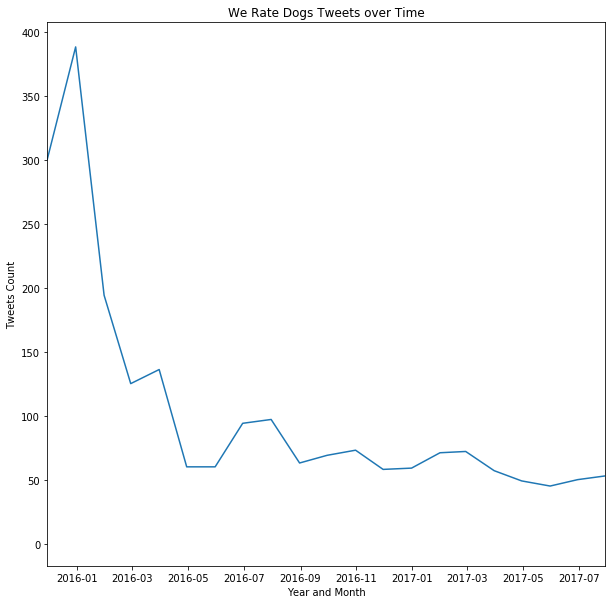

In [82]:
plt.figure(figsize=(10, 10));
plt.xlim([datetime.date(2015, 11, 30), datetime.date(2017, 7, 30)]);

plt.xlabel('Year and Month')
plt.ylabel('Tweets Count')

plt.plot(monthly_tweets.timestamp, monthly_tweets.tweet_id);
plt.title('We Rate Dogs Tweets over Time');

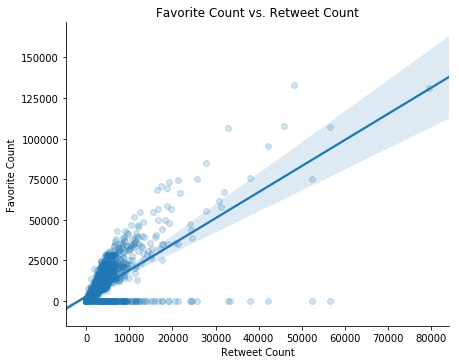

In [83]:
sns.lmplot(x="retweet_count", 
           y="favorite_count", 
           data=dfs,
           size = 5,
           aspect=1.3,
           scatter_kws={'alpha':1/5});

plt.title('Favorite Count vs. Retweet Count');
plt.xlabel('Retweet Count');
plt.ylabel('Favorite Count');

In [84]:
dfs['dog_type'].value_counts()

pupper     244
doggo       84
puppo       32
floofer      4
Name: dog_type, dtype: int64

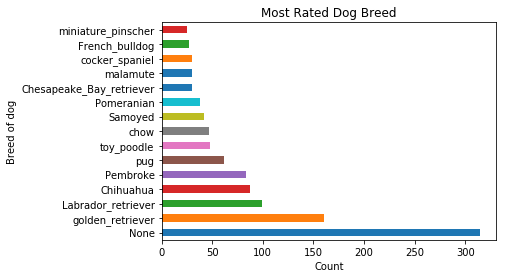

In [85]:
dog_breed = dfs.groupby('dog_breed').filter(lambda x: len(x) >= 25)

dog_breed['dog_breed'].value_counts().plot(kind = 'barh')
plt.title('Most Rated Dog Breed')
plt.xlabel('Count')
plt.ylabel('Breed of dog');